<a href="https://colab.research.google.com/github/FSchijve/Capita-Selecta-gr-5/blob/main/Copy_of_Rotation%2Bshearing%2Bscaling%2Bflipping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch WMH basic U-Net

Link to data: https://drive.google.com/drive/folders/1urcqcK2k-XPR7t-BJtMLrlHdZaEMiud5?usp=sharing

Right-click on folder, select 'Add shortcut to Drive -> MyDrive'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Utrecht"

0  11  17  19  2  21  23  25  27  29  31  33  35  37  39  4  41  49  6	8


In [ ]:
# First, we import PyTorch and NumPy
import torch
import numpy as np
import os
# For the augmentations
import torchvision
import random
# These two extra for evaluation.
import difflib
import scipy.spatial
# We import glob to find everything that matches a pattern
from glob import glob
# We install and import SimpleITK for image loading
# pip is the package installer for python
!pip install SimpleITK
import SimpleITK as sitk
# To show data, we import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # progressbar 

     |████████████████████████████████| 47.4MB 67kB/s 


## Data Augmentation Implementations here

Add the augmentation so that for a specific type of augmentation the same augmentation is done for both the target and the image.

Later down in the code, before the data set gets increased, there is a section to plot the image and target. Please test and check there if the augmentation properly works.

In [ ]:
class transforms(): 
  def normalize(self, img, x_min, x_max): 
    max_img = torch.max(img)
    min_img = torch.min(img)
    nom = (img - min_img) * (x_max - x_min)
    denom = max_img - min_img
    denom = denom + (denom == 0) 
    return x_min + nom / denom 

  def rotate(self, img, wmh, degrees): 
    """ Function to rotate both the image and wmh mask with a random rotation in the same way.
    The degrees paramater has to be passed as a range e.g. (-18, 18).
    Has been checked.
    """
    angle = torchvision.transforms.RandomRotation.get_params(degrees)
    rotated_img = torchvision.transforms.functional.rotate(img, angle)
    rotated_wmh = torchvision.transforms.functional.rotate(wmh, angle)
    return rotated_img, rotated_wmh

  def flip(self, img, wmh): # Check if it properly works
    flipped_img = torchvision.transforms.functional.hflip(img = img) # change to .vflip for vertical flip
    flipped_wmh = torchvision.transforms.functional.hflip(img = wmh)
    return flipped_img, flipped_wmh

  def scale(self, img, wmh, range=0.2): # Check if it properly works
    """
    Function to scale both the image and the wmh mask with a random range in the same way
    The range parameter is a float that will create a scaled image in the range of 1+- range
    has not yet been checked to see if it works
    """
    scale = random.randrange((1-range)*1000, (1+range)*1000)/1000
    scaled_img = torchvision.transforms.functional.affine(img=img, angle=0, translate=[0,0], shear=0, scale=scale)
    scaled_wmh = torchvision.transforms.functional.affine(img=wmh, angle=0, translate=[0,0], shear=0, scale=scale)
    return scaled_img, scaled_wmh

  def shear(self, img, wmh, degrees): # Check if it properly works.
    degree = np.random.randint(-degrees, degrees)
    sheared_img = torchvision.transforms.functional.affine(img = img, shear = [degree],
                                                         angle = 0, translate = [0,0], scale = 1)
    sheared_wmh = torchvision.transforms.functional.affine(img = wmh, shear = [degree],
                                                         angle = 0, translate = [0,0], scale = 1)
    return sheared_img, sheared_wmh

## Provided Model With Modifications
Call the augmentation method inside the corresponding if-statement of the __getitem__ function. If your data augmentation method requires an extra parameter (e.g. angle sequence for rotation) I'd recommend creating a tuple in the init function argument list and then unpacking this tuple in the function body (see rotation as example).

In [ ]:
class WMHDataset(torch.utils.data.Dataset):
  # Datasets in Pytorch are classes of the torch.utils.data.Dataset type
  # They __must__ have at least three methods:
  # - __init__ -> Initialize the dataset, the place where you can pass parameters to it
  # - __len__ -> How many samples does your dataset represent?
  # - __getitem__ -> A function which takes a parameter i, and returns the ith sample of the dataset

  # Note that this DOES NOT perform
  # - Batching
  # - Asynchronous dataloading (for speed)
  # - Merge different datasets on the fly 
  # - shuffling the data
  # More examples like these are solved with "higher-order" methods

  # but it __might__ do:
  # - data augmentation of one sample
  # - data normalization of one sample
  # - performing on-the-fly data generation
  # - hides the nitty-gritty details of dealing with files
  def __init__(self, institute, normalize = False, rotate = (False, 0) , flip = False, scale = False, shear = (False, 0)):
    self.institute = institute # in this case, we make a dataset per institute
    if self.institute == 'Amsterdam':
      self.slices = 83
      self.datafolder = glob(f'/content/drive/MyDrive/{self.institute}/GE3T/**') #this notation is called an f-string. It "fills in" the value of the variable in the string
    else:
      self.slices = 48
      self.datafolder = glob(f'/content/drive/MyDrive/{self.institute}/**')
    print(self.datafolder)

    # Initializations for data augmentation
    self.transforms = transforms()

    # I'd suggest passing any extra parameters necessary for the transformation along with the variable as a tuple.
    # Then unpack the tuple here and use it later, when applying the augmentation. This way those parameters are not fixed inside the class.
    self.normalize = normalize
    self.rotate, self.rotation_angle = rotate
    self.flip = flip
    self.scale = scale
    self.shear, self.shear_angle = shear

  def __len__(self): # the length is the number of patients scanned at the institute. Every patient is a subfolder in the institute folder
    return len(self.datafolder) * self.slices

  # This is a helper function to avoid repeating the same SimpleITK function calls to load the images
  # It loads the Nifti files, gets a correctly spaced NumPy array, and creates a tensor
  def read_image(self, path):
    img = sitk.ReadImage(path)
    img_as_numpy = sitk.GetArrayFromImage(img).astype('float') # the default type is uint16, which trips up PyTorch so we convert to float
    img_as_tensor = torch.from_numpy(img_as_numpy)
    return img_as_tensor

  def __getitem__(self, i): # return the ith sample of the dataset, note that 0 <= i < len(dataset)
    # A slice is considered a sample.

    # do some math to check out which slice we want in which folder
    folder_index = i // self.slices # Confusion arises. How does this work e.g. when i = 70, since there is no folder 1.
    slice_index = i % self.slices
    # first we get the paths to the T1 and FLAIR images, and the WMH mask
    wmh_path = f'{self.datafolder[folder_index]}/wmh.nii.gz' # Aah so the index is for the array and the value is the actual one in the folder.
    t1_path = f'{self.datafolder[folder_index]}/pre/T1.nii.gz'
    flair_path = f'{self.datafolder[folder_index]}/pre/FLAIR.nii.gz'

    # Actually load the Nifti files and create PyTorch tensors
    wmh = self.read_image(wmh_path)
    t1 = self.read_image(t1_path)
    flair = self.read_image(flair_path)

    # TODO: Data from different institutes are not the same size, crop?
    _, x, y = wmh.size()
    train_tensor = torch.zeros((1, x, y)) # Use only one to avoid error shown.
    target_tensor = torch.zeros((1, x, y))

    # train_tensor[0, ...] = t1[slice_index, ...]
    train_tensor[0, ...] = flair[slice_index, ...] # Suppose only using t1 images to avoid the warning. Put Flair in 0 was in 1.

    target_tensor[0, ...] = wmh[slice_index, ...]

    # Apply normalization
    if self.normalize:
      train_tensor = self.transforms.normalize(train_tensor, 0, 1)

    # Apply data augmentation
    if self.rotate:
      train_tensor, target_tensor = self.transforms.rotate(train_tensor, target_tensor, self.rotation_angle)
    
    if self.flip:
      train_tensor, target_tensor = self.transforms.flip(train_tensor, target_tensor)
    
    if self.scale:
      train_tensor, target_tensor = self.transforms.scale(train_tensor, target_tensor)
    
    if self.shear:
      train_tensor, target_tensor = self.transforms.shear(train_tensor, target_tensor, self.shear_angle)

    # Return the samples as PyTorch tensors
    return train_tensor, target_tensor


In [ ]:
#Load the data
dataset = WMHDataset('Utrecht') # Note this dataset is now already normalized.
print(dataset.datafolder[0]) # I think if we remove the first 3 * 48 samples that corresponds with removing the first 3 folders shown below.
len(dataset)

['/content/drive/MyDrive/Utrecht/27', '/content/drive/MyDrive/Utrecht/17', '/content/drive/MyDrive/Utrecht/23', '/content/drive/MyDrive/Utrecht/0', '/content/drive/MyDrive/Utrecht/11', '/content/drive/MyDrive/Utrecht/2', '/content/drive/MyDrive/Utrecht/29', '/content/drive/MyDrive/Utrecht/21', '/content/drive/MyDrive/Utrecht/19', '/content/drive/MyDrive/Utrecht/25', '/content/drive/MyDrive/Utrecht/4', '/content/drive/MyDrive/Utrecht/41', '/content/drive/MyDrive/Utrecht/31', '/content/drive/MyDrive/Utrecht/39', '/content/drive/MyDrive/Utrecht/49', '/content/drive/MyDrive/Utrecht/6', '/content/drive/MyDrive/Utrecht/35', '/content/drive/MyDrive/Utrecht/37', '/content/drive/MyDrive/Utrecht/33', '/content/drive/MyDrive/Utrecht/8']
/content/drive/MyDrive/Utrecht/27


960

In [ ]:
#Take a look at what the data looks like
train, target = dataset[323] # OG: 323
train.size() # Note: t1 in 0 and flair in 1.

torch.Size([1, 240, 240])

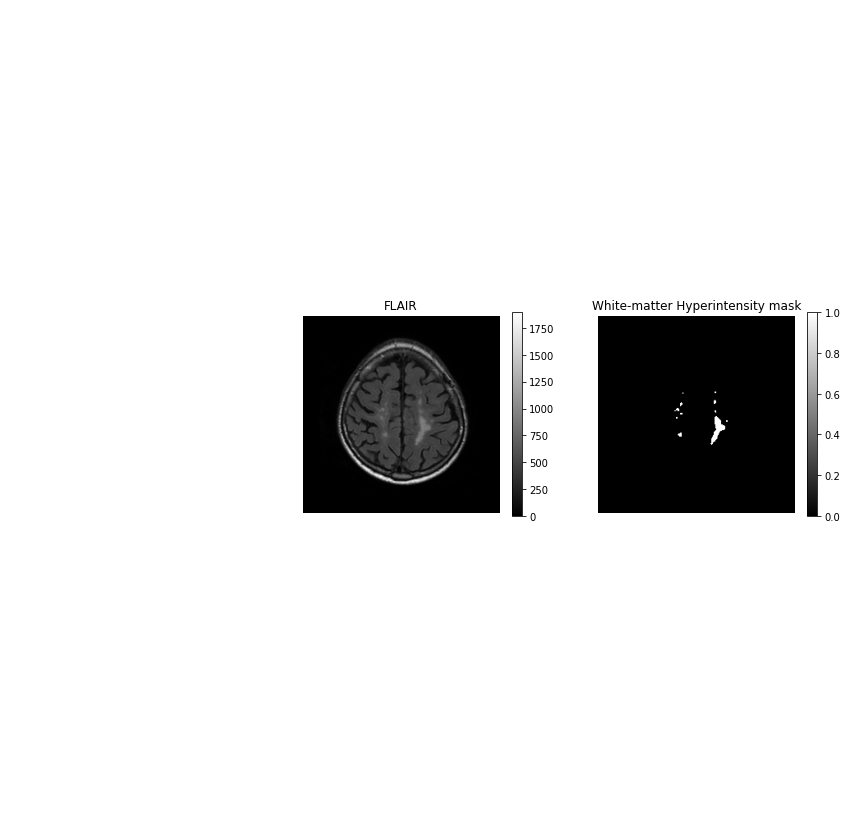

In [ ]:
# create the figure
showFig = 'yes'

if showFig=='yes':
  f, ax = plt.subplots(1, 3, figsize=(15, 15))

  # turn off axis to remove ticks and such
  [a.axis('off') for a in ax]

  # Here we plot it at the actual subplot we want. We set the colormap to gray (feel free to experiment)
  # t1_plot = ax[0].imshow(train[0, :, :], cmap='gray')
  flair_plot = ax[1].imshow(train[0, :, :], cmap='gray') # Was one but we only working with flair for now.
  wmh_plot = ax[2].imshow(target[0, :, :], cmap='gray')

  # Add titles and colorbar
  # ax[0].set_title('T1')
  ax[1].set_title('FLAIR')
  ax[2].set_title('White-matter Hyperintensity mask')

  # f.colorbar(t1_plot, ax=ax[0], shrink=0.25)
  f.colorbar(flair_plot, ax=ax[1], shrink=0.25)
  f.colorbar(wmh_plot, ax=ax[2], shrink=0.25)

In [ ]:
import torch.nn as nn # Basic building blocks (containers, different layers ect.)

def double_conv(in_channels, out_channels): 
    return nn.Sequential( # a sequential container, elements are kept in order
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        # 3 is the size of the kernel? Padding is zero padding  
        nn.ReLU(inplace=True),
        # Activation function ReLU = applies the rectified linear unit function element wise 
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):
  # nn.Module is the base class for all neural network modules

    def __init__(self, n_class, n_channels):
      #Initialization, number of classes, number of channels
        super().__init__()
        # The U-shape         
        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2) # a 2x2 kernel 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
def train_epoch(model, optimizer, train_loader, lossfunction, device='cuda'):
  model.train()
  total_loss = 0
  for batch_idx, (train, target) in enumerate(tqdm(train_loader)):
    train, target = train.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(train)
    loss = lossfunction(target, output)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

  return total_loss / len(train_loader)

In [ ]:
def test_epoch(model, test_loader, eval_function, device='cuda'):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for batch_idx, (train, target) in enumerate(tqdm(test_loader)):
      train, target = train.to(device), target.to(device) 
      output = model(train)
      loss = eval_function(target, output)
      total_loss += loss.item()

  return total_loss / len(test_loader)

In [ ]:
def train_model(train_loader, test_loader, optimizer, lossfunction, eval_function=None, epochs=25, device='cuda'):
  if eval_function is None:
    eval_function = lossfunction
  train_losses = []
  test_losses = []
  for epoch in range(epochs):
    print('[Epoch %d / %d]' % (epoch + 1, epochs))
    train_loss = train_epoch(model, optimizer, train_loader, lossfunction, device)
    test_loss = test_epoch(model, test_loader, eval_function, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
  return train_losses, test_losses

In [ ]:
import torch.optim as optim

device='cuda'
model = UNet(1,1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Increase dataset with augmentations
Note: I'd suggest creating proper variable names for the specific augmentation happening.

In [ ]:
# Modifications on dataset should come bout here, in this and next cell.
dataset_all_transforms = WMHDataset('Utrecht', rotate = (True, (-18, 18)), shear=(True, 30), scale =True, flip = True)


['/content/drive/MyDrive/Utrecht/27', '/content/drive/MyDrive/Utrecht/17', '/content/drive/MyDrive/Utrecht/23', '/content/drive/MyDrive/Utrecht/0', '/content/drive/MyDrive/Utrecht/11', '/content/drive/MyDrive/Utrecht/2', '/content/drive/MyDrive/Utrecht/29', '/content/drive/MyDrive/Utrecht/21', '/content/drive/MyDrive/Utrecht/19', '/content/drive/MyDrive/Utrecht/25', '/content/drive/MyDrive/Utrecht/4', '/content/drive/MyDrive/Utrecht/41', '/content/drive/MyDrive/Utrecht/31', '/content/drive/MyDrive/Utrecht/39', '/content/drive/MyDrive/Utrecht/49', '/content/drive/MyDrive/Utrecht/6', '/content/drive/MyDrive/Utrecht/35', '/content/drive/MyDrive/Utrecht/37', '/content/drive/MyDrive/Utrecht/33', '/content/drive/MyDrive/Utrecht/8']


## Take a look at the augmented dataset

This is the aforementioned place to check and test if the implemented augmentation works for both the image and target and if the applied augmentation is the same for both.

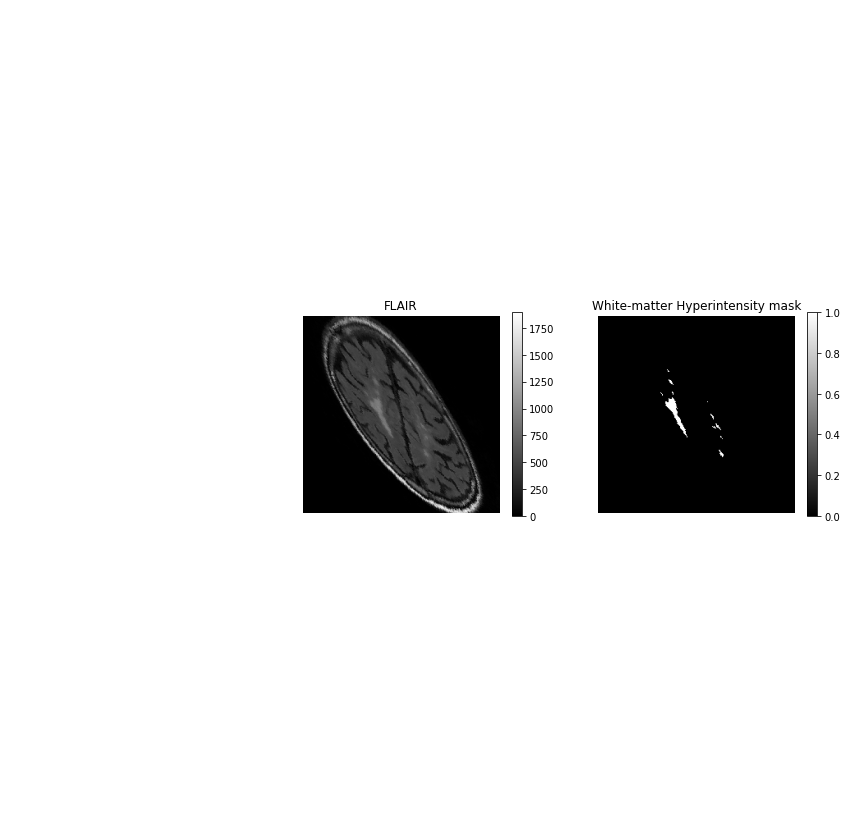

In [ ]:
#Take a look at what the data looks like
train_rotated, target_rotated = dataset_all_transforms[323] # OG:323

# create the figure
showFig_rotated = 'yes'

if showFig_rotated=='yes':
  f, ax = plt.subplots(1, 3, figsize=(15, 15))

  # turn off axis to remove ticks and such
  [a.axis('off') for a in ax]

  # Here we plot it at the actual subplot we want. We set the colormap to gray (feel free to experiment)
  # t1_plot = ax[0].imshow(train[0, :, :], cmap='gray')
  flair_plot_rotated = ax[1].imshow(train_rotated[0, :, :], cmap='gray') # Was one but we only working with flair for now.
  wmh_plot_rotated = ax[2].imshow(target_rotated[0, :, :], cmap='gray')

  # Add titles and colorbar
  # ax[0].set_title('T1')
  ax[1].set_title('FLAIR')
  ax[2].set_title('White-matter Hyperintensity mask')

  # f.colorbar(t1_plot, ax=ax[0], shrink=0.25)
  f.colorbar(flair_plot_rotated, ax=ax[1], shrink=0.25)
  f.colorbar(wmh_plot_rotated, ax=ax[2], shrink=0.25)






  

## Increase the dataset

In [ ]:
print("First three folders of dataset:", dataset.datafolder[0], dataset.datafolder[1], dataset.datafolder[2])
print("Amount of slices per subject", dataset.slices)
print("Calculated test samples", 3 * dataset.slices)

amount_of_test_samples = 3 * dataset.slices

indices = list(range(len(dataset)))

test_indices = indices[:amount_of_test_samples]
train_indices = indices[amount_of_test_samples:]

print("Test indices:", test_indices)
# print("Amount of test indices:", len(test_indices))
# print("Train indices", train_indices)

# First seperate train and test from the real data.
dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset, test_indices)

# Seperate the samples used for testing also from the augmented data set.
# If this is not necessary then remove line below and replace dataset_rotated_train with dataset_rotated in the line after that.
print("First three folders of dataset_rotated:", dataset_all_transforms.datafolder[0], dataset_all_transforms.datafolder[1], dataset_all_transforms.datafolder[2])
dataset_all_transforms = torch.utils.data.Subset(dataset_all_transforms, train_indices)

# Then add augmented dataset to training dataset.
dataset_train = torch.utils.data.ConcatDataset([dataset_train, dataset_all_transforms])

print("")
print("Length of training set: ", len(dataset_train), "\nLength of test set: ", len(dataset_test))

First three folders of dataset: /content/drive/MyDrive/Utrecht/27 /content/drive/MyDrive/Utrecht/17 /content/drive/MyDrive/Utrecht/23
Amount of slices per subject 48
Calculated test samples 144
Test indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
First three folders of dataset_rotated: /content/drive/MyDrive/Utrecht/27 /content/drive/MyDrive/Utrecht/17 /content/drive/MyDrive/Utrecht/23

Length of training set:  1632 
Length 

# Start Training

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True) # add num_workers parameter, put it to something 2-4. And maybe increase batch_size.
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=False)

losses = train_model(train_loader, test_loader, optimizer, torch.nn.MSELoss(), device=device, epochs=30)

[Epoch 1 / 30]


KeyboardInterrupt: ignored

In [ ]:
#Visualize the loss
plt.plot(losses[0], label="training")
plt.plot(losses[1], label="test")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend(loc="upper left")

NameError: ignored

## Save the model
I'd suggest taking care in saving the model for a certain augmentation set, by giving it another name or saving it in a different location to make sure it won't be overwritten when saving another trained model.

In [ ]:
#Store/save model
data_path = '/content/drive/MyDrive/'
torch.save(model.state_dict(), data_path + 'WMH_segmentation.pt')

#Re-load model
loaded_model = UNet(1,1)
loaded_model.load_state_dict(torch.load(data_path + 'WMH_segmentation.pt'))

<All keys matched successfully>

#Evaluation metrics

Get the prediction for a single image based on the trained U-Net.

In [ ]:
inputDir = '/content/drive/MyDrive/Utrecht'
dir_name = '23' # Make sure to pick one of the subjects in testing: probs 27, 17, 23
resultDir = '/content/drive/MyDrive/Results/Utrecht'
if not os.path.isdir(resultDir):
  os.mkdir(resultDir)

img_FLAIR = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(inputDir, dir_name, 'pre', 'FLAIR.nii.gz'))).astype('float')
img_wmh = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(inputDir, dir_name, 'wmh.nii.gz'))).astype('float')

tensor_FLAIR = torch.from_numpy(img_FLAIR)
tensor_wmh = torch.from_numpy(img_wmh)

dataloader = torch.utils.data.DataLoader(tensor_FLAIR, batch_size = 1, shuffle=True)
pred = torch.zeros(tensor_wmh.size())

# model = UNet(1,1)
# model = model.to(device)
model.eval()

for ind, input in enumerate(tqdm(dataloader)):
  with torch.no_grad():
    input = input.unsqueeze(0)
    input = input.to(device, dtype=torch.float)
    output = model(input)
    pred[ind, ...] = output

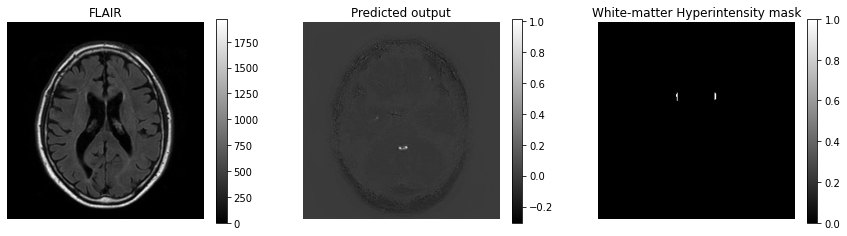

In [ ]:
  f, ax = plt.subplots(1, 3, figsize=(15, 15))

  # turn off axis to remove ticks and such
  [a.axis('off') for a in ax]

  # Here we plot it at the actual subplot we want. We set the colormap to gray (feel free to experiment)
  slice = 24 # Feel free to change, 48 slices for Utrecht.
  test_plot = ax[0].imshow(tensor_FLAIR[slice, :, :], cmap='gray')
  pred_plot = ax[1].imshow(pred[slice, :, :], cmap='gray')
  target_plot = ax[2].imshow(tensor_wmh[slice, :, :], cmap='gray')

  # Add titles and colorbar
  ax[0].set_title('FLAIR')
  ax[1].set_title('Predicted output')
  ax[2].set_title('White-matter Hyperintensity mask')

  f.colorbar(test_plot, ax=ax[0], shrink=0.25) # Guess this is just for the colorbar.
  f.colorbar(pred_plot, ax=ax[1], shrink=0.25)
  f.colorbar(target_plot, ax=ax[2], shrink=0.25)

In [ ]:
# Writes result of previous selected subject.
filename_resultImage = os.path.join(resultDir, dir_name, 'result.nii.gz')
sitk.WriteImage(sitk.GetImageFromArray(pred.numpy()), filename_resultImage )
filename_testImage = os.path.join(inputDir, dir_name, 'wmh.nii.gz')

## Evaluation Metrics: Dice, HD, AVD, Recall, F1.

In [ ]:
# Set the path to the source data (e.g. the training data for self-testing)
# and the output directory of that subject
testDir        = os.path.join(inputDir, dir_name) # For example: '/data/Utrecht/0'
participantDir = os.path.join(resultDir, dir_name) # For example: '/output/teamname/0'.

# In light of the previous evaluation subsection this has been put to the inputDir and resultDir provided there.

In [ ]:
def do():
    """Main function"""
    resultFilename = getResultFilename(participantDir)  
        
    testImage, resultImage = getImages(os.path.join(testDir, 'wmh.nii.gz'), resultFilename)
    
    dsc = getDSC(testImage, resultImage)
    h95 = getHausdorff(testImage, resultImage)
    avd = getAVD(testImage, resultImage)    
    recall, f1 = getLesionDetection(testImage, resultImage)    
    
    print('Dice',                dsc,       '(higher is better, max=1)')
    print('HD',                  h95, 'mm',  '(lower is better, min=0)')
    print('AVD',                 avd,  '%',  '(lower is better, min=0)')
    print('Lesion detection', recall,       '(higher is better, max=1)')
    print('Lesion F1',            f1,       '(higher is better, max=1)')
    

def getImages(testFilename, resultFilename):
    """Return the test and result images, thresholded and non-WMH masked."""
    testImage   = sitk.ReadImage(testFilename)
    resultImage = sitk.ReadImage(resultFilename)
    
    # Check for equality
    assert testImage.GetSize() == resultImage.GetSize()
    
    # Get meta data from the test-image, needed for some sitk methods that check this
    resultImage.CopyInformation(testImage)
    
    # Remove non-WMH from the test and result images, since we don't evaluate on that
    maskedTestImage = sitk.BinaryThreshold(testImage, 0.5,  1.5, 1, 0) # WMH == 1    
    nonWMHImage     = sitk.BinaryThreshold(testImage, 1.5,  2.5, 0, 1) # non-WMH == 2
    maskedResultImage = sitk.Mask(resultImage, nonWMHImage)
    
    # Convert to binary mask
    if 'integer' in maskedResultImage.GetPixelIDTypeAsString():
        bResultImage = sitk.BinaryThreshold(maskedResultImage, 1, 1000, 1, 0)
    else:
        bResultImage = sitk.BinaryThreshold(maskedResultImage, 0.5, 1000, 1, 0)
        
    return maskedTestImage, bResultImage
    

def getResultFilename(participantDir):
    """Find the filename of the result image.
    
    This should be result.nii.gz or result.nii. If these files are not present,
    it tries to find the closest filename."""
    files = os.listdir(participantDir)
    
    if not files:
        raise Exception("No results in "+ participantDir)
    
    resultFilename = None
    if 'result.nii.gz' in files:
        resultFilename = os.path.join(participantDir, 'result.nii.gz')
    elif 'result.nii' in files:
        resultFilename = os.path.join(participantDir, 'result.nii')
    else:
        # Find the filename that is closest to 'result.nii.gz'
        maxRatio = -1
        for f in files:
            currentRatio = difflib.SequenceMatcher(a = f, b = 'result.nii.gz').ratio()
            
            if currentRatio > maxRatio:
                resultFilename = os.path.join(participantDir, f)
                maxRatio = currentRatio
                
    return resultFilename
    
    
def getDSC(testImage, resultImage):    
    """Compute the Dice Similarity Coefficient."""
    testArray   = sitk.GetArrayFromImage(testImage).flatten()
    resultArray = sitk.GetArrayFromImage(resultImage).flatten()
    
    # similarity = 1.0 - dissimilarity
    return 1.0 - scipy.spatial.distance.dice(testArray, resultArray) 
    

def getHausdorff(testImage, resultImage):
    """Compute the Hausdorff distance."""
    
    # Hausdorff distance is only defined when something is detected
    resultStatistics = sitk.StatisticsImageFilter()
    resultStatistics.Execute(resultImage)
    if resultStatistics.GetSum() == 0:
        return float('nan')
        
    # Edge detection is done by ORIGINAL - ERODED, keeping the outer boundaries of lesions. Erosion is performed in 2D
    eTestImage   = sitk.BinaryErode(testImage, (1,1,0) )
    eResultImage = sitk.BinaryErode(resultImage, (1,1,0) )
    
    hTestImage   = sitk.Subtract(testImage, eTestImage)
    hResultImage = sitk.Subtract(resultImage, eResultImage)    
    
    hTestArray   = sitk.GetArrayFromImage(hTestImage)
    hResultArray = sitk.GetArrayFromImage(hResultImage)   
        
    # Convert voxel location to world coordinates. Use the coordinate system of the test image
    # np.nonzero   = elements of the boundary in numpy order (zyx)
    # np.flipud    = elements in xyz order
    # np.transpose = create tuples (x,y,z)
    # testImage.TransformIndexToPhysicalPoint converts (xyz) to world coordinates (in mm)
    testCoordinates   = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hTestArray) ))]
    resultCoordinates = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hResultArray) ))]
        
            
    # Use a kd-tree for fast spatial search
    def getDistancesFromAtoB(a, b):    
        kdTree = scipy.spatial.KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]
    
    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(testCoordinates, resultCoordinates)
    dResultToTest = getDistancesFromAtoB(resultCoordinates, testCoordinates)    
    
    return max(np.percentile(dTestToResult, 95), np.percentile(dResultToTest, 95))
    
    
def getLesionDetection(testImage, resultImage):    
    """Lesion detection metrics, both recall and F1."""
    
    # Connected components will give the background label 0, so subtract 1 from all results
    ccFilter = sitk.ConnectedComponentImageFilter()    
    ccFilter.SetFullyConnected(True)
    
    # Connected components on the test image, to determine the number of true WMH.
    # And to get the overlap between detected voxels and true WMH
    ccTest = ccFilter.Execute(testImage)    
    lResult = sitk.Multiply(ccTest, sitk.Cast(resultImage, sitk.sitkUInt32))
    
    ccTestArray = sitk.GetArrayFromImage(ccTest)
    lResultArray = sitk.GetArrayFromImage(lResult)
    
    # recall = (number of detected WMH) / (number of true WMH) 
    nWMH = len(np.unique(ccTestArray)) - 1
    if nWMH == 0:
        recall = 1.0
    else:
        recall = float(len(np.unique(lResultArray)) - 1) / nWMH
    
    # Connected components of results, to determine number of detected lesions
    ccResult = ccFilter.Execute(resultImage)
    lTest = sitk.Multiply(ccResult, sitk.Cast(testImage, sitk.sitkUInt32))
    
    ccResultArray = sitk.GetArrayFromImage(ccResult)
    lTestArray = sitk.GetArrayFromImage(lTest)
    
    # precision = (number of detections that intersect with WMH) / (number of all detections)
    nDetections = len(np.unique(ccResultArray)) - 1
    if nDetections == 0:
        precision = 1.0
    else:
        precision = float(len(np.unique(lTestArray)) - 1) / nDetections
    
    if precision + recall == 0.0:
        f1 = 0.0
    else:
        f1 = 2.0 * (precision * recall) / (precision + recall)
    
    return recall, f1    

    
def getAVD(testImage, resultImage):   
    """Volume statistics."""
    # Compute statistics of both images
    testStatistics   = sitk.StatisticsImageFilter()
    resultStatistics = sitk.StatisticsImageFilter()
    
    testStatistics.Execute(testImage)
    resultStatistics.Execute(resultImage)
        
    return float(abs(testStatistics.GetSum() - resultStatistics.GetSum())) / float(testStatistics.GetSum()) * 100

In [ ]:
do()

Dice 0.009433962264150941 (higher is better, max=1)
HD 63.007223401476054 mm (lower is better, min=0)
AVD 8.433734939759036 % (lower is better, min=0)
Lesion detection 0.09523809523809523 (higher is better, max=1)
Lesion F1 0.06451612903225808 (higher is better, max=1)
